https://www.kaggle.com/sshikamaru/car-object-detection

In [67]:
import os
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd

In [68]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [69]:
%cd /content/drive/My Drive/Colab Notebooks/Machine Learning Projects/(Kaggle) Car Object Detection/Dataset

/content/drive/My Drive/Colab Notebooks/Machine Learning Projects/(Kaggle) Car Object Detection/Dataset


In [70]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/Machine Learning Projects/(Kaggle) API Token"

In [71]:
!kaggle datasets download -d sshikamaru/car-object-detection

car-object-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


# Loading Data

In [72]:
label = pd.read_csv('data/train_solution_bounding_boxes.csv')
label.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764800,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020261,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [103]:
training_image_path = 'data/training_images/'
testing_image_path = 'data/testing_images/'

In [86]:
plot.shape

(380, 676, 3)

# Exploratory Data Analysis

In [101]:
print('Training Image:', len(os.listdir(training_image_path)))
print('Testing Image:', len(os.listdir(testing_image_path)))

Training Image: 1001
Testing Image: 175


In [160]:
def plot(img_num):
  image = os.listdir(training_image_path)[img_num]
  plot = plt.imread(training_image_path + image)

  bbox = label[label['image'] == image]

  fig, ax = plt.subplots(figsize=(8, 5))

  for i in range(len(bbox)):
    xmin = bbox.iloc[i]['xmin']
    ymin = bbox.iloc[i]['ymin']
    xmax = bbox.iloc[i]['xmax']
    ymax = bbox.iloc[i]['ymax']
    width = xmax - xmin
    height = ymax - ymin
    rect = Rectangle([xmin, ymin], width, height, color='r', fill=False)
    plt.gca().add_patch(rect)

  ax.imshow(plot)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()

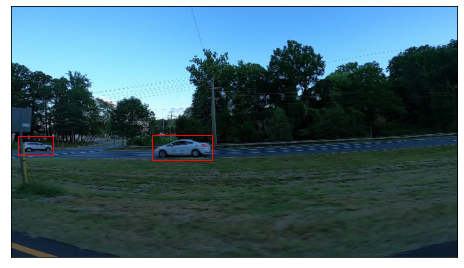

In [161]:
plot(950)

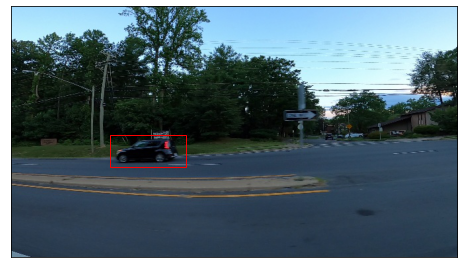

In [162]:
plot(55)

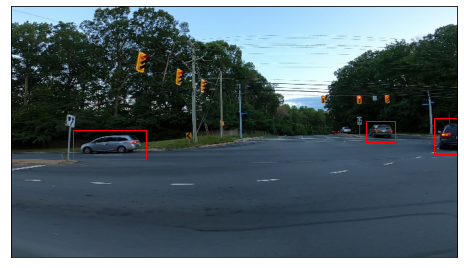

In [166]:
plot(102)